In [ ]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

In [3]:
import pandas as pd
import numpy as np
from sklearn import linear_model, cross_validation
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model, cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Formatting the raw data

In [63]:
raw_data = pd.read_csv('winequality-red.csv')
raw_data = pd.read_csv('winequality-red.csv', sep = ';', header = None)
new_header = raw_data.iloc[0] #grab the first row for the header
df = raw_data[1:].astype(float) #take the data less the header row
df.columns = new_header #set the header row as the df header

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0


# Splitting data into training and testing (80/20) sets 

In [48]:
# Next, we set the quality of the wine as the y column, and split the data into training and test data sets

target_column = ['quality'] 
predictors = list(set(list(df.columns))-set(target_column))
X = df[predictors].values
y = df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)


# Ordinary Least Squares, with intercept and normalizing

In [6]:
lr = LinearRegression(fit_intercept=True, normalize=True).fit(X_train, y_train)
pred_train_lr= lr.predict(X_train)
pred_test_lr= lr.predict(X_test)

In [7]:
print("Training Data Results:")
print("Mean squared error: %s" % mean_squared_error(y_train,pred_train_lr))
print("R Squared: %s" % r2_score(y_train, pred_train_lr))

Training Data Results:
Mean squared error: 0.41914135600144115
R Squared: 0.3435138143942261


In [8]:
print("Testing Data Results:")
print("Mean squared error: %s" % mean_squared_error(y_test,pred_test_lr))
print("R Squared: %s" % r2_score(y_test, pred_test_lr))

Testing Data Results:
Mean squared error: 0.40938401510422534
R Squared: 0.4183385391256862


Note: The model performed well on the testing data, indicating that there is no overfitting and our model is good.

# Coefficients of OLS model

In [19]:
coeff_lr = pd.DataFrame(np.append(lr.intercept_,lr.coef_.transpose()), ['Intercept'] + predictors, columns=['Coefficients']) 
coeff_lr

,Coefficients
Intercept,21.201403
citric acid,-0.174033
chlorides,-1.810628
alcohol,0.271437
free sulfur dioxide,0.004230
volatile acidity,-1.034351
density,-17.129773
pH,-0.393833
total sulfur dioxide,-0.003296
sulphates,0.833811


# Using k-fold CV to find alpha parameter for ridge regression

In [69]:
rr = Ridge(fit_intercept=True, normalize=True)
parameters = np.arange(0, 50, 0.01)

ridge_regressor = GridSearchCV(rr, {'alpha': parameters} , scoring="neg_mean_squared_error",
                               cv=10,return_train_score = True)

ridge_regressor.fit(X_train,y_train)

cve_error = -1* ridge_regressor.best_score_ # error is negative score
print("After k-fold cv, we found the best alpha value to be %s with error of %s" 
      % (ridge_regressor.best_params_['alpha'], cve_error) )


After k-fold cv, we found the best alpha value to be 0.05 with error of 0.42719659336479276


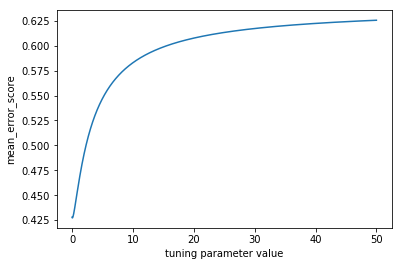

In [70]:
plt.xlabel("tuning parameter value")
plt.ylabel("mean_error_score")
plt.plot(parameters, -1*ridge_regressor.cv_results_["mean_test_score"])
plt.show()

Let's try using a more specific range of values to fine tuning our parameter

In [24]:
fine_rr = Ridge(fit_intercept=True, normalize=True)
parameters = np.arange(0, .1, 0.001)

ridge_regressor = GridSearchCV(fine_rr, {'alpha': parameters} , scoring="neg_mean_squared_error",
                               cv=10,return_train_score = True)

ridge_regressor.fit(X_train,y_train)

cve_error = -1* ridge_regressor.best_score_ # error is negative score
print("After a finer tune, we found the best alpha value to be %s with error of %s" 
      % (ridge_regressor.best_params_['alpha'], cve_error) )


After a finer tune, we found the best alpha value to be 0.054 with error of 0.42719360628905756


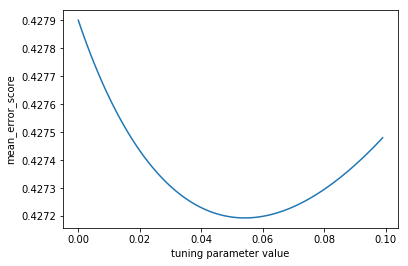

In [25]:
plt.xlabel("tuning parameter value")
plt.ylabel("mean error score")
plt.plot(parameters, -1*ridge_regressor.cv_results_["mean_test_score"])
plt.show()

In [26]:
# test cv ridge regression model on training and test set
cv_rr = Ridge(fit_intercept=True, normalize=True, alpha = 0.054).fit(X_train, y_train)

pred_train_rr= cv_rr.predict(X_train)
pred_test_rr= cv_rr.predict(X_test)

In [27]:
print("Training Data Results:")
print("Mean squared error: %s" % mean_squared_error(y_train,pred_train_rr))
print("R Squared: %s" % r2_score(y_train, pred_train_rr))

Training Data Results:
Mean squared error: 0.41966708492918714
R Squared: 0.34269038388922635


In [28]:
print("Testing Data Results:")
print("Mean squared error: %s" % mean_squared_error(y_test,pred_test_rr))
print("R Squared: %s" % r2_score(y_test, pred_test_rr))

Testing Data Results:
Mean squared error: 0.4127119537574192
R Squared: 0.41361013355219545


Note: again the model fits the testing data well. Using all the data, we will proceed to train a ridge regression model with the optimal alpha and display the weights of the features in a table.

# Coefficients of Ridge Regression model

In [29]:
coeff_rr = pd.DataFrame(np.append(cv_rr.intercept_,cv_rr.coef_.transpose()), ['Intercept'] + predictors, columns=['Coefficients']) 
coeff_rr

,Coefficients
Intercept,30.979037
citric acid,-0.074723
chlorides,-1.745374
alcohol,0.248620
free sulfur dioxide,0.003576
volatile acidity,-0.968760
density,-27.127704
pH,-0.293352
total sulfur dioxide,-0.003106
sulphates,0.801991


# Using k-fold CV to find alpha parameter for lasso regression

In [74]:
lar = Lasso(fit_intercept=True, normalize=True)
parameters = np.arange(0, 50, 0.1)

lasso_regressor = GridSearchCV(lar, {'alpha': parameters} , scoring="neg_mean_squared_error",
                               cv=10,return_train_score = True)

lasso_regressor.fit(X_train,y_train)

cv_error_lar = -1* lasso_regressor.best_score_ # error is negative score
print("After k-fold cv, we found best alpha value to be %s with error of %s" 
      % (lasso_regressor.best_params_['alpha'], cv_error_lar) )


/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimato

After k-fold cv, we found best alpha value to be 0.0 with error of 0.42790045491771045


/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


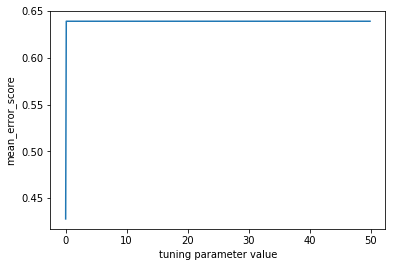

In [75]:
plt.xlabel("tuning parameter value")
plt.ylabel("mean_error_score")
plt.plot(parameters, -1*lasso_regressor.cv_results_["mean_test_score"])
plt.show()

Note: Again, let us do a finer tune

In [80]:
lar = Lasso(fit_intercept=True, normalize=True)
parameters = np.arange(0, .01, 0.0001)

lasso_regressor = GridSearchCV(lar, {'alpha': parameters} , scoring="neg_mean_squared_error",
                               cv=10,return_train_score = True)

lasso_regressor.fit(X_train,y_train)

cv_error_lar = -1* lasso_regressor.best_score_ # error is negative score
print("After k-fold cv, we found best alpha value to be %s with error of %s" 
      % (lasso_regressor.best_params_['alpha'], cv_error_lar) )


/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimato

After k-fold cv, we found best alpha value to be 0.0002 with error of 0.4276526827775983


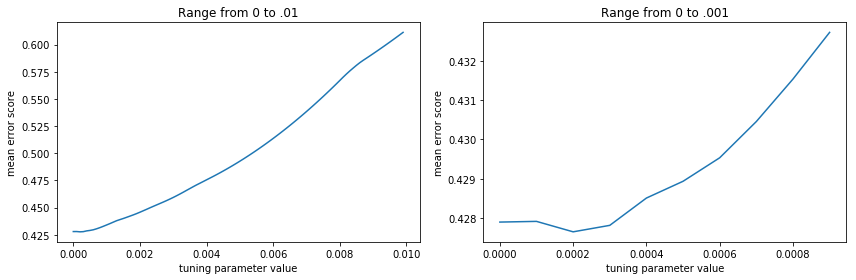

In [102]:
x1 = np.arange(0, .01, 0.0001)
x2 = np.arange(0, .001, 0.0001)

y1 = -1*lasso_regressor.cv_results_["mean_test_score"]
y2 = -1*lasso_regressor.cv_results_["mean_test_score"][:10]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x1, y1)
plt.title('Range from 0 to .01')
plt.ylabel("mean error score")
plt.xlabel("tuning parameter value")

plt.subplot(1, 2, 2)
plt.plot(x2, y2)
plt.title('Range from 0 to .001')
plt.xlabel("tuning parameter value")
plt.ylabel("mean error score")
plt.tight_layout()

plt.show()

In [115]:
# test cv lasso regression model on training and test set

cv_lar = Lasso(fit_intercept=True, normalize=True, alpha = .0002).fit(X_train, y_train) 
pred_train_la= cv_lar.predict(X_train)
pred_test_la= cv_lar.predict(X_test)

In [116]:
print("Training Data Results:")
print("Mean squared error: %s" % mean_squared_error(y_train,pred_train_la))
print("R Squared: %s" % r2_score(y_train, pred_train_la))

Training Data Results:
Mean squared error: 0.42033505336426963
R Squared: 0.34164416870722736


In [117]:
print("Testing Data Results:")
print("Mean squared error: %s" % mean_squared_error(y_test,pred_test_la))
print("R Squared: %s" % r2_score(y_test, pred_test_la))

Testing Data Results:
Mean squared error: 0.41303925872643255
R Squared: 0.41314509173472425


# Coefficients of Lasso model

In [118]:
coeff_lar = pd.DataFrame(np.append(cv_lar.intercept_,cv_lar.coef_.transpose()), ['Intercept'] + predictors, columns=['Coefficients']) 
coeff_lar

,Coefficients
Intercept,4.200448
citric acid,-0.000000
chlorides,-1.677439
alcohol,0.280748
free sulfur dioxide,0.002716
volatile acidity,-0.981772
density,-0.000000
pH,-0.379928
total sulfur dioxide,-0.002836
sulphates,0.743150


Note: a slight change in alpha value drasitcally changes our feature weights. Consider, the case when we use alpha = 0 instead of .0002. We get a table that is much more similar to our previous models.

In [120]:
cv_lar0 = Lasso(fit_intercept=True, normalize=True, alpha = 0).fit(X_train, y_train) 

coeff_lar0 = pd.DataFrame(np.append(cv_lar0.intercept_,cv_lar0.coef_.transpose()), ['Intercept'] + predictors, columns=['Coefficients']) 
coeff_lar0

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """Entry point for launching an IPython kernel.
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Coefficients
Intercept,21.201403
citric acid,-0.174033
chlorides,-1.810628
alcohol,0.271437
free sulfur dioxide,0.004230
volatile acidity,-1.034351
density,-17.129773
pH,-0.393833
total sulfur dioxide,-0.003296
sulphates,0.833811


# Using k-fold CV to find alpha and l1_ratio parameters for ElasticNet

In [227]:
er = ElasticNet(fit_intercept=True, normalize=True)

alphas1 = np.arange(0,5,.1)
l1_ratio1 = np.arange(0.0, 1, 0.1)
parametersGrid = {"alpha": alphas1,
                      "l1_ratio": l1_ratio1}

er_regressor = GridSearchCV(er, parametersGrid, scoring="neg_mean_squared_error",cv=5,return_train_score = True)
er_regressor.fit(X_train,y_train)

best_alpha = er_regressor.best_params_['alpha']
best_l1_ratio = round(er_regressor.best_params_['l1_ratio'],3)

print("After k-fold cv, we found the best alpha value to be %s, and l1_ratio to be %s with error of %s" 
      % (best_alpha,best_l1_ratio, -1* er_regressor.best_score_) )

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimato

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very sm

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/g

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

After k-fold cv, we found the best alpha value to be 0.0, and l1_ratio to be 0.0 with error of 0.4301277784918643


/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small a

Note: we fine tune some more:

In [226]:
er2 = ElasticNet(fit_intercept=True, normalize=True)

alphas2 = np.arange(0,.5,.1)
l1_ratio2 = np.arange(0.0, .005, .001)
parametersGrid = {"alpha": alphas2,
                      "l1_ratio": l1_ratio2}

er_regressor2 = GridSearchCV(er, parametersGrid, scoring="neg_mean_squared_error",cv=5,return_train_score = True)
er_regressor2.fit(X_train,y_train)

best_alpha2 = er_regressor2.best_params_['alpha']
best_l1_ratio2 = round(er_regressor2.best_params_['l1_ratio'],3)

print("After k-fold cv, we found the best alpha value to be %s, and l1_ratio to be %s with error of %s" 
      % (best_alpha2,best_l1_ratio2, -1*er_regressor2.best_score_) )

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimato

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very sm

After k-fold cv, we found the best alpha value to be 0.0, and l1_ratio to be 0.0 with error of 0.4301277784918643


/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

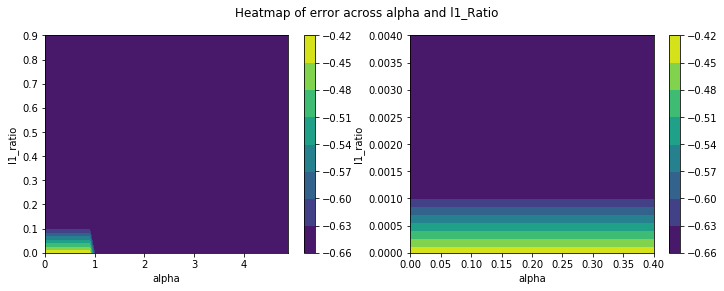

In [225]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Heatmap of error across alpha and l1_Ratio ')

X1, Y1 = np.meshgrid(alphas1, l1_ratio1)
Z1 = np.reshape(er_regressor.cv_results_['mean_test_score'], X1.shape)

p_plot = ax1.contourf(X1, Y1, Z1)
fig.colorbar(p_plot, ax=ax1)
ax1.set(xlabel='alpha', ylabel='l1_ratio')

X2, Y2 = np.meshgrid(alphas2, l1_ratio2)
Z2 = np.reshape(er_regressor2.cv_results_['mean_test_score'], X2.shape)

run_plot = ax2.contourf(X2, Y2, Z2)
fig.colorbar(run_plot, ax=ax2)
ax2.set(xlabel='alpha', ylabel='l1_ratio')

plt.show()

# Coefficients of the Elastic Net model

In [223]:
cv_en = ElasticNet(fit_intercept=True, normalize=True, alpha = 0, l1_ratio = .00).fit(X_train, y_train) 

coeff_en = pd.DataFrame(np.append(cv_en.intercept_,cv_en.coef_.transpose()), ['Intercept'] + predictors, columns=['Coefficients']) 
coeff_en

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """Entry point for launching an IPython kernel.
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Coefficients
Intercept,21.201403
citric acid,-0.174033
chlorides,-1.810628
alcohol,0.271437
free sulfur dioxide,0.004230
volatile acidity,-1.034351
density,-17.129773
pH,-0.393833
total sulfur dioxide,-0.003296
sulphates,0.833811


In [229]:
# test cv lasso regression model on training and test set

cv_en = ElasticNet(fit_intercept=True, normalize=True, alpha = 0, l1_ratio = 0).fit(X_train, y_train) 
pred_train_en = cv_en.predict(X_train)
pred_test_en = cv_en.predict(X_test)

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/garyzhu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [230]:
print("Training Data Results:")
print("Mean squared error: %s" % mean_squared_error(y_train,pred_train_en))
print("R Squared: %s" % r2_score(y_train, pred_train_en))

Training Data Results:
Mean squared error: 0.419141356001441
R Squared: 0.34351381439422646


In [231]:
print("Testing Data Results:")
print("Mean squared error: %s" % mean_squared_error(y_test,pred_test_en))
print("R Squared: %s" % r2_score(y_test, pred_test_en))

Testing Data Results:
Mean squared error: 0.40938401510422373
R Squared: 0.4183385391256884


Conclusion, it seems like OLS and Elastic net barely have the best MSE and R^2 scores